In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix


In [3]:
import matplotlib.pyplot as plt

In [4]:
import sys 
import pickle

In [5]:
sys.path.append('../../')

In [6]:
from omd2l.data.StocksData import StocksData
from omd2l.models.linear import SoftmaxRegressionTabular
from omd2l.models.MLP import DropoutMLP
from omd2l.models.base.Trainer import Trainer

In [7]:
with open("./feat_alpha_df.pickle", "rb") as handle:
    data = pickle.load(handle)

In [8]:
data['ff_alpha_direction'] = 1.0*(data['ff_alpha']>0)

In [9]:
FEATURES = [ 
 'px_rank',
 'range',
 'prior_ret',
 'DollarVolume',
 'Beta',
 'SecBeta',
 'market_relative_prior_ret',
 'sector_relative_prior_ret' ]
RESPONSE = ['ff_alpha_direction']

In [10]:
data['tradeDate'] = pd.to_datetime(data['date']).dt.date

In [11]:
data[FEATURES] = data.groupby('tradeDate')[FEATURES].apply(
    lambda x: (x - x.mean()) / (x.std())).copy()

<AxesSubplot:>

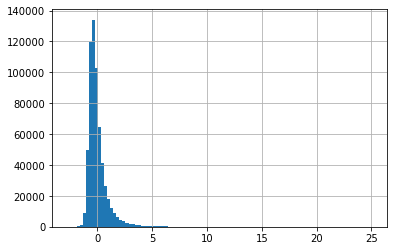

In [12]:
data['range'].hist(bins=100)

In [13]:
data = StocksData(batch_size=1000,features=FEATURES, response=RESPONSE)

In [14]:
data.preprocess()

In [15]:
from sklearn.model_selection import KFold

In [16]:
with open("./feat_alpha_df.pickle", "rb") as handle:
    dataset = pickle.load(handle)
dataset['ff_alpha_direction'] = 1.0*(dataset['ff_alpha']>0)
dataset['tradeDate'] = pd.to_datetime(dataset['date']).dt.date
dataset.sort_values(by = 'tradeDate',ascending=True, inplace = True)
dataset.reset_index(drop = True, inplace = True)

In [17]:
import math

def divisorGenerator(n):
    large_divisors = []
    for i in range(1, int(math.sqrt(n) + 1)):
        if n % i == 0:
            yield i
            if i*i != n:
                large_divisors.append(n / i)
    for divisor in reversed(large_divisors):
        yield divisor

In [18]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.dataset.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        train_data = data.dataset.drop(index=idx).copy(deep=True)
        train_data.reset_index(inplace = True)
        divisors = list(divisorGenerator(train_data.shape[0]))

        test_data = data.dataset.loc[idx]
        test_data.reset_index(inplace = True)
        fold_data = StocksData(batch_size=  10000, 
                               features=FEATURES, 
                               response=RESPONSE,
                                raw_train=train_data,
                                raw_val=test_data)
        fold_data.preprocess()
        rets.append(fold_data)
    return rets

In [19]:
 def validation_epoch(trained_model,
                 validation_dataloader,
                
                 device):
    validation_loss, validation_correct_predictions = 0.0, 0
    trained_model.eval()
    with torch.no_grad():
        for validation_data, validation_labels in validation_dataloader:
            validation_data, validation_labels = validation_data.to(device),validation_labels.to(device)
            output = trained_model(validation_data)
            loss=trained_model.loss(output,validation_labels)
            validation_loss+=loss.item()*validation_data.size(0)
            scores, predictions = torch.max(output.data,1)
            validation_correct_predictions+=np.diag(confusion_matrix(y_pred= predictions  , 
                                                                     y_true =  validation_labels ) ).sum()

    return validation_loss,validation_correct_predictions

In [20]:
def k_fold(trainer, data, k, model ):
    val_loss, val_acc, models = [], [], [] 
    for i, data_fold in enumerate(k_fold_data(data, k)):
        print(f"Fold: {i}" )
        model.board.yscale='log'
        model.board.display = False
        trainer.fit(model, data_fold)
#         val_loss.append(float(model.board.data['val_loss'][-1].y))
        
        validation_loss,validation_correct_predictions =  validation_epoch(model,
                 data_fold.val_dataloader(),
                
                 device='cpu')
        
        print(f"Validation loss: {validation_loss}")
        print(f"Validation accuracy: {validation_correct_predictions/data_fold.val.shape[0]}")
              
        val_loss.append(validation_loss)
        val_acc.append(validation_correct_predictions/data_fold.val.shape[0])
        
        models.append(model)
    avg_val_log_loss = sum(val_loss)/len(val_loss)
    avg_val_acc = sum(val_acc)/len(val_acc)
    return models, avg_val_log_loss, avg_val_acc

In [21]:
lr_hparams = {'num_outputs':2,'lr':0.001}
lr_model = SoftmaxRegressionTabular(**lr_hparams)

/Users/oualid/opt/miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [22]:
mlp_hparams = {'num_outputs':2, 
               'num_hiddens_1':10, 
               'num_hiddens_2':10,
               'dropout_1':0.1, 
               'dropout_2':0.1, 
               'lr':0.001}

In [23]:
mlp_model = DropoutMLP(**mlp_hparams)

In [24]:
mdls = {'lr': lr_model, 'mlp': mlp_model}
# mdls = {'mlp': mlp_model}

for name, mdl in mdls.items():
    print(f"Model: {name}")
    trainer = Trainer(max_epochs=10)
    models, avg_val_log_loss , avg_val_acc= k_fold(trainer, data, k=5, model=mdl)
    print(f'{name}: average validation loss = {avg_val_log_loss}, accuracy = {avg_val_acc}')


Model: lr
Fold: 0
Validation loss: nan
Validation accuracy: 0.5189003436426117
Fold: 1
Validation loss: nan
Validation accuracy: 0.47344064060169877
Fold: 2
Validation loss: nan
Validation accuracy: 0.4724923815081372
Fold: 3
Validation loss: nan
Validation accuracy: 0.4659680347532905
Fold: 4
Validation loss: nan
Validation accuracy: 0.46723238021137264
lr: average validation loss = nan, accuracy = 0.4796067561434222
Model: mlp
Fold: 0
Validation loss: nan
Validation accuracy: 0.4816264669649225
Fold: 1
Validation loss: nan
Validation accuracy: 0.47344064060169877
Fold: 2
Validation loss: nan
Validation accuracy: 0.4724923815081372
Fold: 3
Validation loss: nan
Validation accuracy: 0.4659680347532905
Fold: 4
Validation loss: nan
Validation accuracy: 0.46723238021137264
mlp: average validation loss = nan, accuracy = 0.47215198080788434


In [25]:
BREAK

NameError: name 'BREAK' is not defined

In [ ]:
k=5
for name, model in mdls.items():
    print(f"Model: {name}")
    trainer = Trainer(max_epochs=10)
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        print(f"Fold: {i}" )
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        if i==0:
            break
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    avg_val_log_loss = sum(val_loss)/len(val_loss)

In [ ]:
model.board.data['val_loss'][-1].y

In [ ]:
model.board.data['val_acc'][-1].y

In [ ]:
X, y = next(iter(data_fold.val_dataloader()))
preds = model(X).argmax(axis=1)
preds.shape

In [ ]:
yhat = model(data_fold.val)

In [ ]:
kfold = KFold(n_splits=5, shuffle=True)
# # K-fold Cross Validation model evaluation
history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    train_data = dataset.iloc[train_ids,:]
    test_data = dataset.iloc[test_ids,:]
    
#     data.x = data.x.to(torch.float)


    
    train_tensors = TensorDataset(torch.from_numpy(train_data[FEATURES].values).to(torch.float) ,  # X
                                torch.from_numpy(train_data[RESPONSE].values).to(torch.float) )   # Y

    train_loader = torch.utils.data.DataLoader( train_tensors,
                                           batch_size=1000,
                                           shuffle=True )
    
    test_tensors = TensorDataset(torch.from_numpy(test_data[FEATURES].values).to(torch.float) ,  # X
                                torch.from_numpy(test_data[RESPONSE].values).to(torch.float) )   # Y

    test_loader = torch.utils.data.DataLoader( test_tensors,
                                           batch_size=1000,
                                           shuffle=True )   
    
    trainer.fit(model, train_loader)
